In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:33667' processes=6 threads=24, memory=125.20 GiB>

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [4]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

# salterature of meltwater at the freezing point calculated with the in situ salinity:
Tfreezing_insituS = 'accessom2-GPC004'
# temperature of meltwater at the freezing point calculated with the 0 salinity:
Tfreezing_zeroS = 'accessom2-GPC005'
# temperature of meltwater equal to the minimum of the above two temperatures:
Tfreezing_min = 'accessom2-GPC006'
# idem GPC008 but BG03 like, basal distributed between front and 50m deeper:
Tfreezing_min_bg03 = 'accessom2-GPC007'
# temperature of meltwater equal to  min( Tfreezing(s=0),Tinsitu)
Tfreezing_min_s0 = 'accessom2-GPC008'
# calving interpolation
calving = 'accessom2-GPC010'
# calving interpolated in ocean_sbc
calving_sbc = 'accessom2-GPC011'
# realistic calving + conservative temperature + tfreezing as in GPC006 / calving put in runoff array - test
Tfreezing_min_calv_2 = 'accessom2-GPC013'


start_time='2151-01-01'
end_time='2152-01-01'

lat_slice  = slice(-80,-59)

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/']
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC013


0it [00:00, ?it/s]


0

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [7]:
# First plot map of bottom temperature to see where we want to plot transects

In [7]:
start_time='2151-01-01'
end_time='2152-01-01'

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_con = temp_con.mean('time')

temp_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min = temp_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_Tfreezing_min = temp_Tfreezing_min.mean('time')

temp_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.mean('time')

In [8]:
# select out bottom values:
depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_Tfreezing_min = temp_Tfreezing_min.where(depth_array.st_ocean >= max_depth)
bottom_temp_Tfreezing_min = bottom_temp_Tfreezing_min.sum(dim = 'st_ocean')
bottom_temp_Tfreezing_min = bottom_temp_Tfreezing_min.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

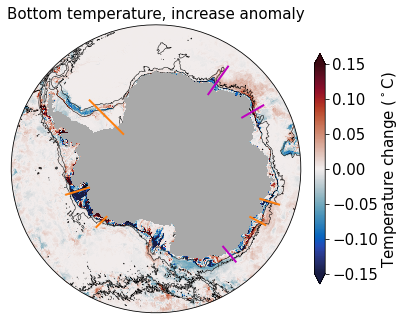

In [9]:
scale_max = 0.15

fig  = plt.figure(1, figsize = (10,8))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# up:
# setup stereo projection:
ax = fig.add_axes([0.0, 0.5, 0.5, 0.5],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_min-bottom_temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Bottom temperature, increase anomaly',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())

# Add transect lines:
#Wedell
plt.plot([-45,-45],[-80,-70],'C1',linewidth=2,transform = ccrs.PlateCarree())
# AmundsenE:
plt.plot([-107,-107],[-75,-70],'C1',linewidth=2,transform = ccrs.PlateCarree())
# AmundsenW:
plt.plot([-135,-135],[-75,-72],'C1',linewidth=2,transform = ccrs.PlateCarree())
# warm patch just downstream of Mertz:
plt.plot([-220,-220],[-68,-64],'m',linewidth=2,transform = ccrs.PlateCarree())
# cooling in Totten:
plt.plot([-242,-242],[-67.5,-64],'C1',linewidth=2,transform = ccrs.PlateCarree())
# cold patch in Vincennes Bay:
plt.plot([-253,-253],[-67,-63],'C1',linewidth=2,transform = ccrs.PlateCarree())
# warm patch downstream of PrydzE:
plt.plot([60,60],[-69,-64],'m',linewidth=2,transform = ccrs.PlateCarree())
# warm patch downstream of PrydzW:
plt.plot([35.5,35.5],[-71,-64],'m',linewidth=2,transform = ccrs.PlateCarree())
        
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.47, 0.55, 0.015, 0.4])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Temperature change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

#figure_path = figdir+'map_bottom_temp_with_transect_locations.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

In [11]:
#Temperature transects

In [10]:
zlevel1 = 0
zlevel2 = 1600

first_year = '2151'
last_year = '2152'

start_time=first_year+'-01-01'
end_time=last_year+'-01-01'

def get_transect_data(lon,lat1,lat2):
    lat_slice  = slice(lat1, lat2)

    # import bathymetry:
    ht_transect = cc.querying.getvar(control,'ht',master_session,n=1)
    ht_transect = ht_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice)
    ht_transect = ht_transect.load()
    ht_transect[np.isnan(ht_transect)] = 0

    ### load data for this period:
    temp_con_transect = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_con_transect = temp_con_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    temp_con_transect = temp_con_transect.load()

    temp_Tfreezing_min_transect = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_Tfreezing_min_transect = temp_Tfreezing_min_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    temp_Tfreezing_min_transect = temp_Tfreezing_min_transect.load()

    ### load data for this period:
    salt_con_transect = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_con_transect = salt_con_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    salt_con_transect = salt_con_transect.load()

    salt_Tfreezing_min_transect = cc.querying.getvar(Tfreezing_min, 'salt', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_Tfreezing_min_transect = salt_Tfreezing_min_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    salt_Tfreezing_min_transect = salt_Tfreezing_min_transect.load()

    ### also get density for plotting isopycnals:
    rho0_con = cc.querying.getvar(control,'pot_rho_0' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_con = rho0_con.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    rho0_con = rho0_con.load()

    rho0_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'pot_rho_0', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_Tfreezing_min = rho0_Tfreezing_min.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    rho0_Tfreezing_min = rho0_Tfreezing_min.load()
    
    
    return ht_transect,temp_con_transect,temp_Tfreezing_min_transect,salt_con_transect,salt_Tfreezing_min_transect,rho0_con,rho0_Tfreezing_min


In [11]:
zlevel1 = 0
zlevel2 = 1600

first_year = '2151'
last_year = '2152'

start_time=first_year+'-01-01'
end_time=last_year+'-01-01'

def get_transect_extra_data(lon,lat1,lat2,extrasim):
    lat_slice  = slice(lat1, lat2)

    # import bathymetry:
    ht_transect = cc.querying.getvar(control,'ht',master_session,n=1)
    ht_transect = ht_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice)
    ht_transect = ht_transect.load()
    ht_transect[np.isnan(ht_transect)] = 0
    
    temp_extra_transect = cc.querying.getvar(extrasim, 'temp', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_extra_transect = temp_extra_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    temp_extra_transect = temp_extra_transect.load()
    
    salt_extra_transect = cc.querying.getvar(extrasim, 'salt', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_extra_transect = salt_extra_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    salt_extra_transect = salt_extra_transect.load()
    
    rho0_extra = cc.querying.getvar(extrasim, 'pot_rho_0', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_extra = rho0_extra.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    rho0_extra = rho0_extra.load()
    
    return ht_transect,temp_extra_transect,salt_extra_transect,rho0_extra

In [24]:
def plot_transects(region):

    if region == 'AmundsenW':
        lon = -135
        lat1 = -74.7
        lat2 = -73
    elif region == 'AmundsenE':
        lon = -107
        lat1 = -75
        lat2 = -70
    elif region == 'Mertz':
        lon = -220
        lat1 = -66.8
        lat2 = -64.5
    elif region == 'Totten':
        lon = -242
        lat1 = -67.2
        lat2 = -64
    elif region == 'Vincennes':
        lon = -253
        lat1 = -67
        lat2 = -63
    elif region == 'PrydzE':
        lon = 60
        lat1 = -67.5
        lat2 = -64    
    elif region == 'PrydzW':
        lon = 35.5
        lat1 = -69.5
        lat2 = -66 
    elif region == 'Wedell':
        lon = -45
        lat1 = -80
        lat2 = -70

    ht_transect,temp_con_transect,temp_Tfreezing_min_transect,salt_con_transect,salt_Tfreezing_min_transect,rho0_con,rho0_Tfreezing_min = get_transect_data(lon,lat1,lat2+.1)
    
    ####
    #ht_transect,temp_extra_transect,salt_extra_transect,rho0_extra = get_transect_extra_data(lon,lat1,lat2+.1,Tfreezing_min)
    #temp_con_transect,salt_con_transect,rho0_con = temp_extra_transect,salt_extra_transect,rho0_extra
    
    extrasim = Tfreezing_min_calv_2
    ht_transect2,temp_extra_transect,salt_extra_transect,rho0_extra = get_transect_extra_data(lon,lat1,lat2+.1,extrasim)
    temp_Tfreezing_min_transect,salt_Tfreezing_min_transect,rho0_Tfreezing_min = temp_extra_transect,salt_extra_transect,rho0_extra
    ####
    
    
    fontsize=16

    fig=plt.figure(figsize=(20,16))

    scale_max = 0.4

    density_contours = [1027.5,1027.6,1027.72,1027.78,1027.81,1027.83,1027.835,1027.84,1027.845,1027.85]

    #### Control temp:
    plt.subplot(2,3,1)
    norm = col.Normalize(vmin=-2,vmax=1.5)
    levels=np.arange(-2,1.65,.05)
    ticks = [-2,-1,0,1]

    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       temp_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### Tfreezing_min temp:
    plt.subplot(2,3,2)
    norm = col.Normalize(vmin=-.2,vmax=.2)
    #levels=np.arange(-.4,.405,.005)
    levels=np.arange(-.2,.205,.005)
    #ticks = [-.4,-.2,0,.2,.4]
    ticks = [-0.2,-.1,0,.1,.2]
    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       temp_Tfreezing_min_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       temp_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_Tfreezing_min,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    plt.title(region+', longitude='+str(lon),fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Temperature anomaly ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #### Control salt:
    plt.subplot(2,3,4)
    norm = col.Normalize(vmin=33.7,vmax=34.8)
    levels=np.arange(33.7,34.81,.01)
    ticks = [33.8,34,34.2,34.4,34.6,34.8]

    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       salt_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Salinity ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### Tfreezing_min salt:
    plt.subplot(2,3,5)
    norm = col.Normalize(vmin=-.1,vmax=.1)
    levels=np.arange(-.1,.101,.001)
    ticks = [-.1,-.05,0,.05,.1]
    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       salt_Tfreezing_min_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       salt_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_Tfreezing_min,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Salinity anomaly',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)

2022-10-18 17:09:54,019 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-10-18 17:09:56,606 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-10-18 17:09:59,301 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-10-18 17:10:02,475 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-10-18 17:10:04,113 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


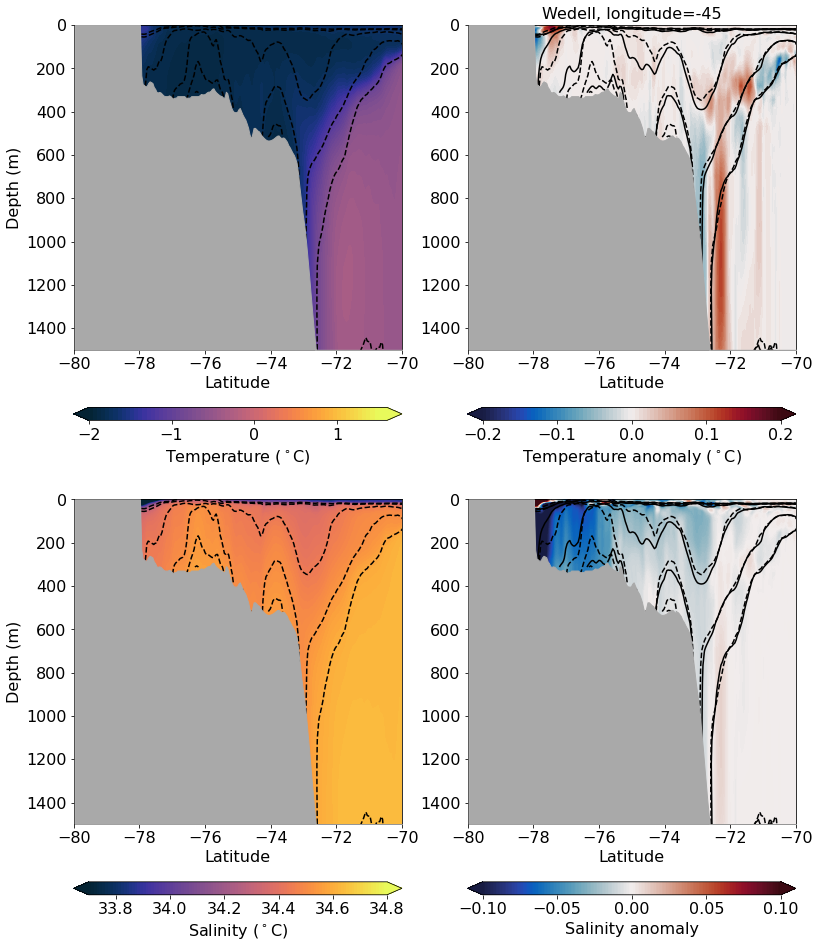

In [25]:
plot_transects('Wedell')

2022-10-18 17:10:09,515 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-10-18 17:10:11,713 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-10-18 17:10:14,346 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-10-18 17:10:17,488 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-10-18 17:10:18,405 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-10-18 17:10:18,983 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


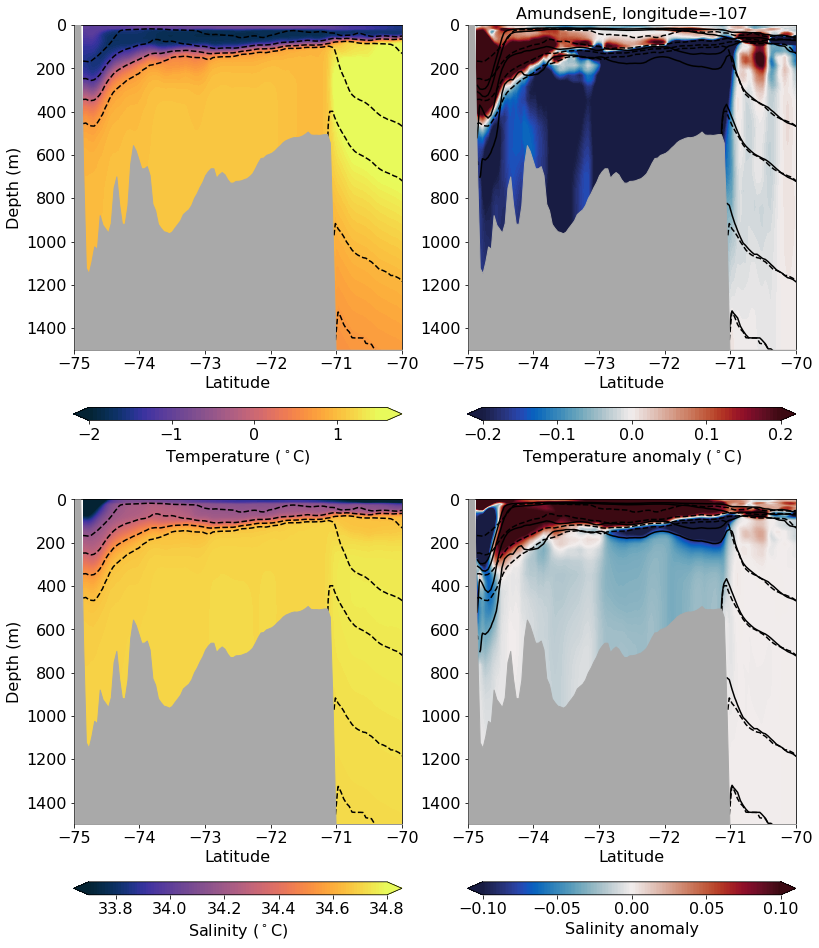

In [26]:
plot_transects('AmundsenE')

2022-10-18 17:10:22,674 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-10-18 17:10:24,424 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-10-18 17:10:24,962 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-10-18 17:10:27,384 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-10-18 17:10:30,220 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-10-18 17:10:30,879 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-10-18 17:10:32,958 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


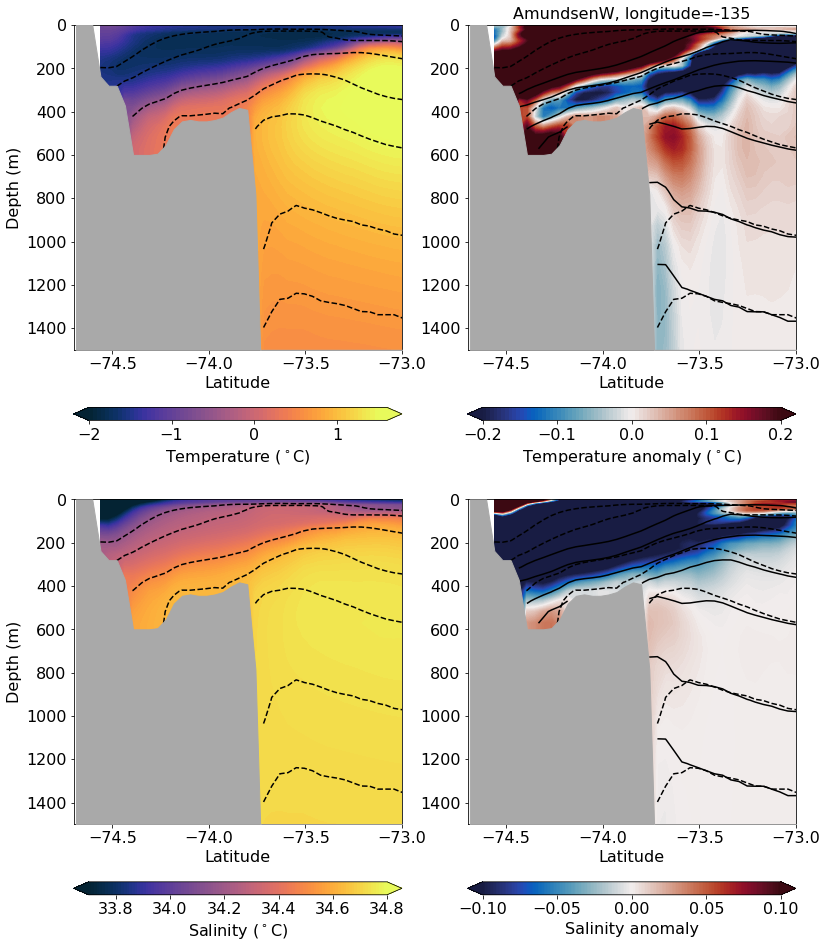

In [27]:
plot_transects('AmundsenW')

2022-10-18 17:10:36,238 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-10-18 17:10:37,393 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-10-18 17:10:39,868 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-10-18 17:10:41,505 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-10-18 17:10:42,103 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-10-18 17:10:44,400 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-10-18 17:10:46,319 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)


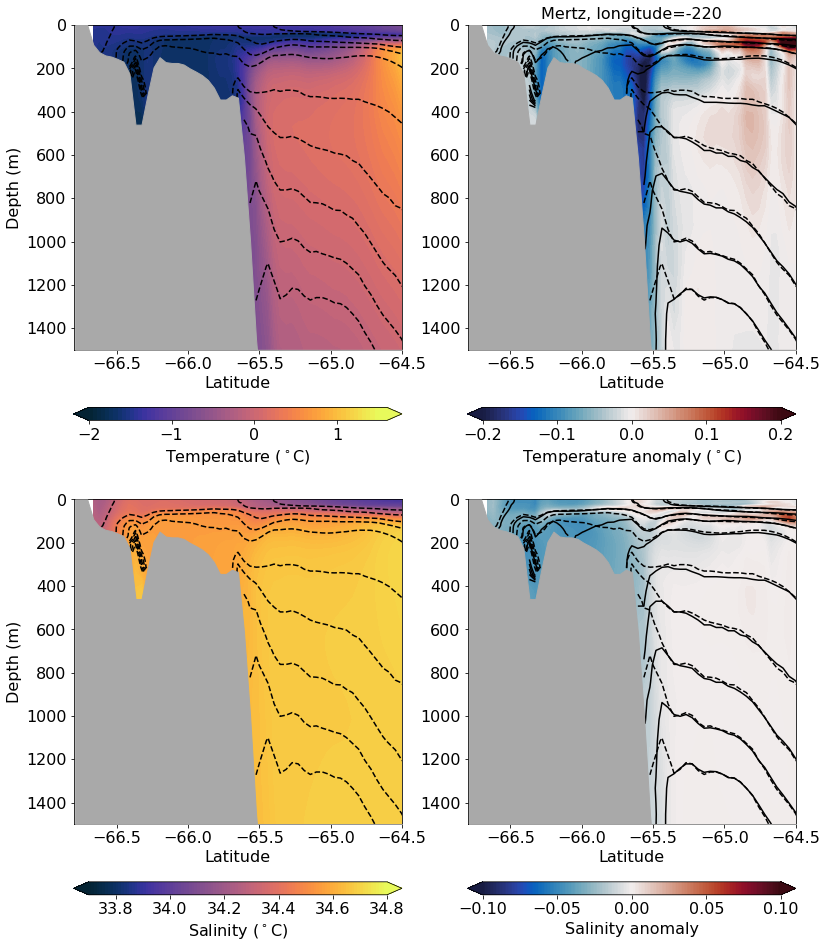

In [28]:
plot_transects('Mertz')

2022-10-18 17:10:49,869 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-10-18 17:10:51,708 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-10-18 17:10:53,949 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-10-18 17:10:55,670 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-10-18 17:10:56,140 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-10-18 17:10:59,027 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-10-18 17:10:59,912 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-10-18 17:11:01,048 - distributed.utils_perf - WARNING - full garbage collections took

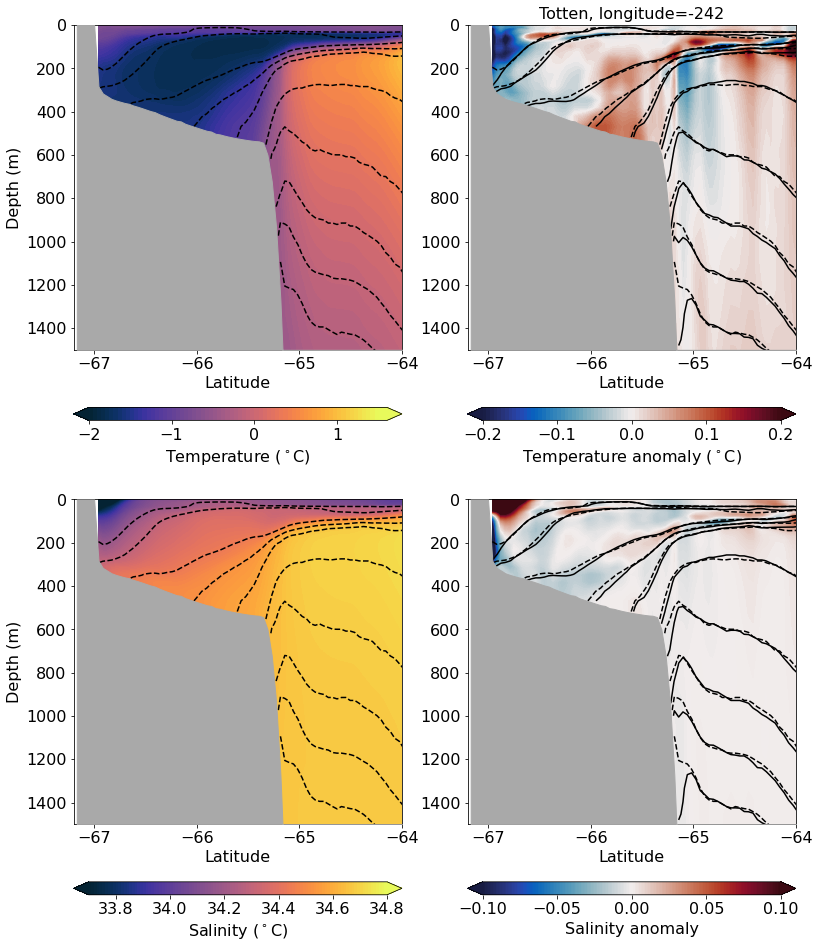

In [29]:
plot_transects('Totten')

2022-10-18 17:11:04,929 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-10-18 17:11:07,230 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-10-18 17:11:08,590 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2022-10-18 17:11:11,169 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-10-18 17:11:12,682 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-10-18 17:11:13,589 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


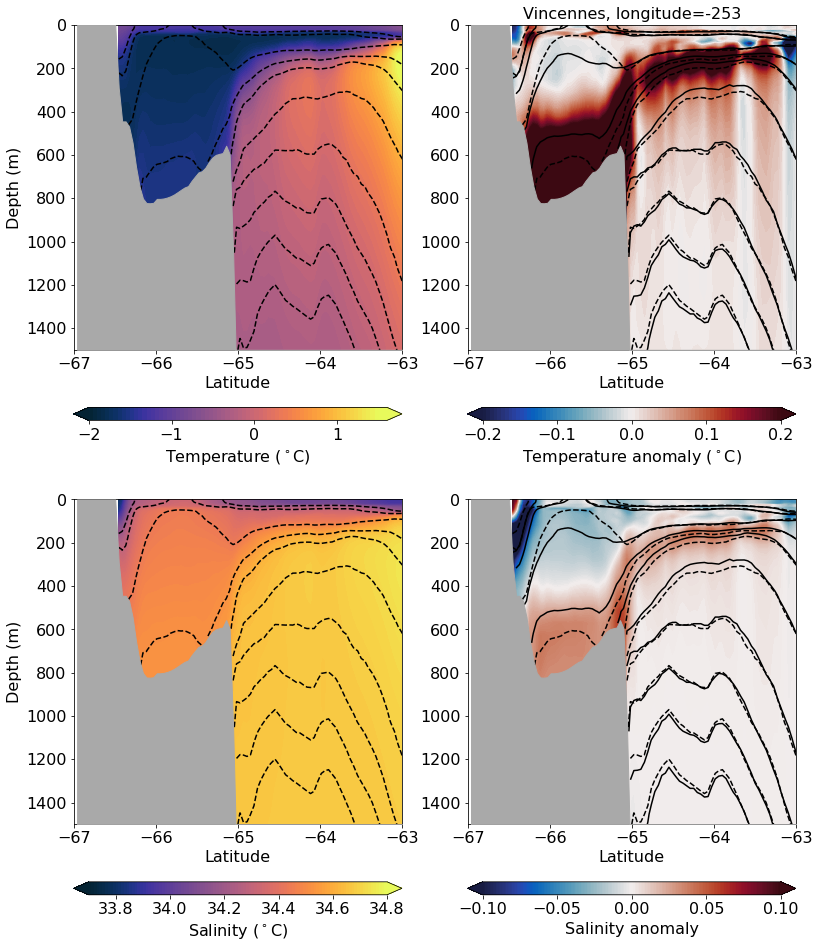

In [30]:
plot_transects('Vincennes')

2022-10-18 17:11:17,375 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-10-18 17:11:19,286 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-10-18 17:11:20,411 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-10-18 17:11:21,717 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-10-18 17:11:24,293 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-10-18 17:11:24,727 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-10-18 17:11:25,686 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-10-18 17:11:26,444 - distributed.utils_perf - WARNING - full garbage collections took

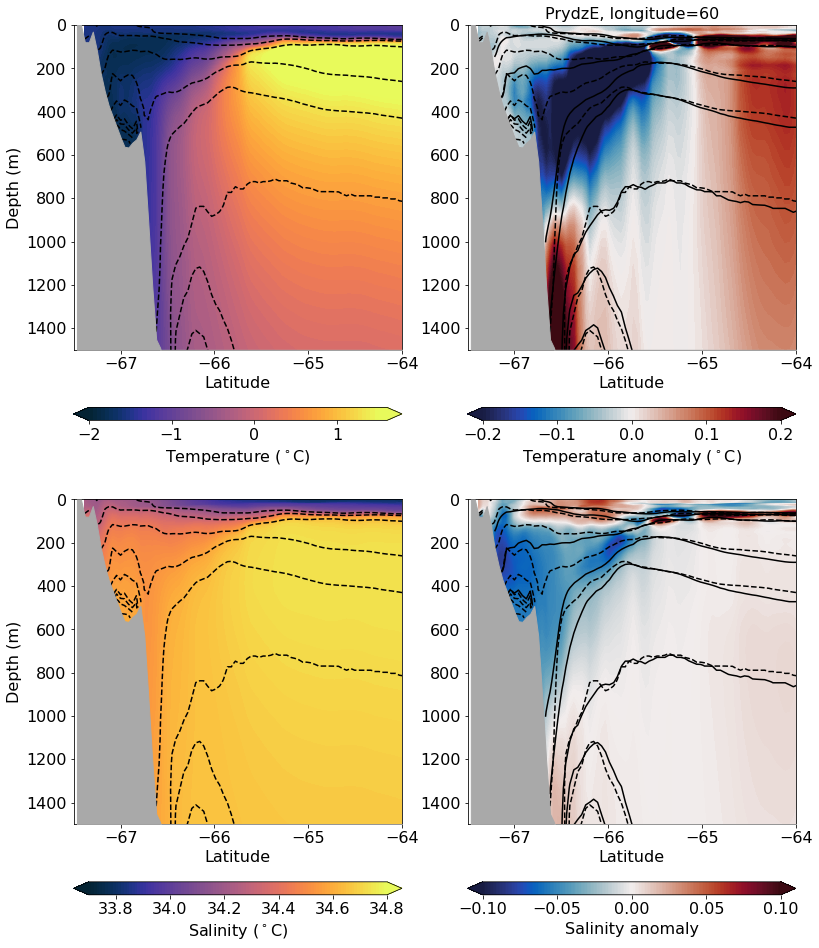

In [31]:
plot_transects('PrydzE')

2022-10-18 17:11:30,518 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-10-18 17:11:32,000 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-10-18 17:11:33,082 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-10-18 17:11:34,547 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-10-18 17:11:35,778 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-10-18 17:11:37,213 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-10-18 17:11:37,234 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-10-18 17:11:38,815 - distributed.utils_perf - WARNING - full garbage collections took

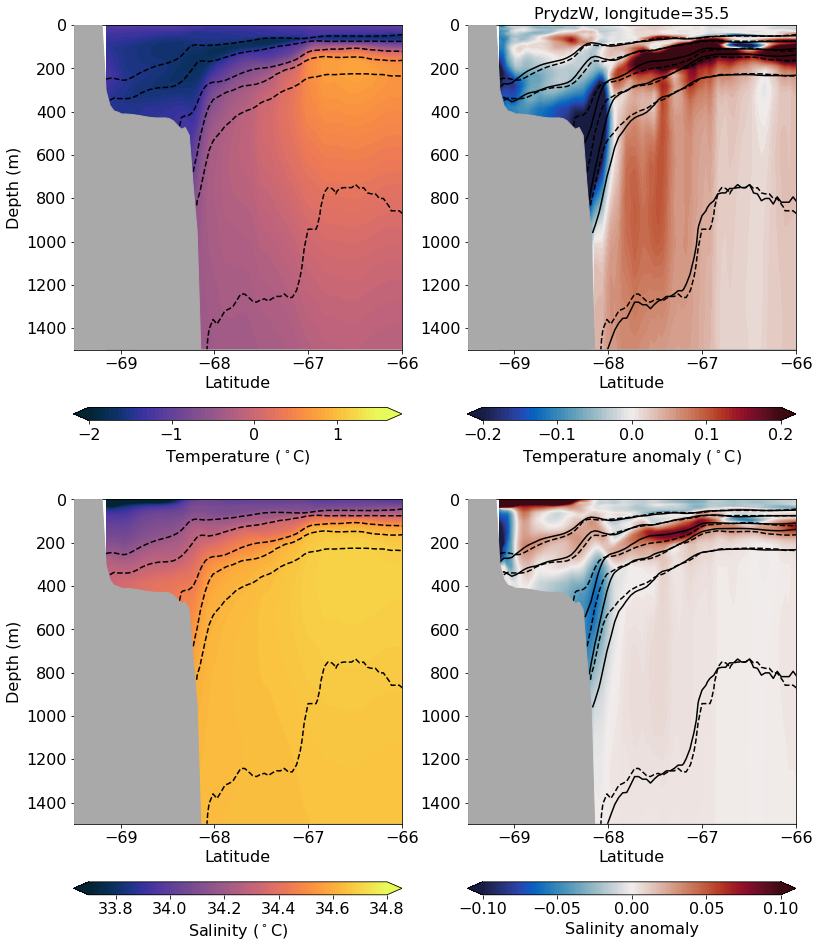

2022-10-18 17:15:20,863 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


In [32]:
plot_transects('PrydzW')

In [23]:
##bg03 diff between simulations

2022-09-22 12:59:41,398 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 12:59:41,474 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2022-09-22 12:59:41,921 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-09-22 12:59:42,926 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-22 12:59:42,930 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-09-22 12:59:43,992 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-22 12:59:44,056 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 12:59:44,456 - distributed.utils_perf - WARNING - full garbage collections took

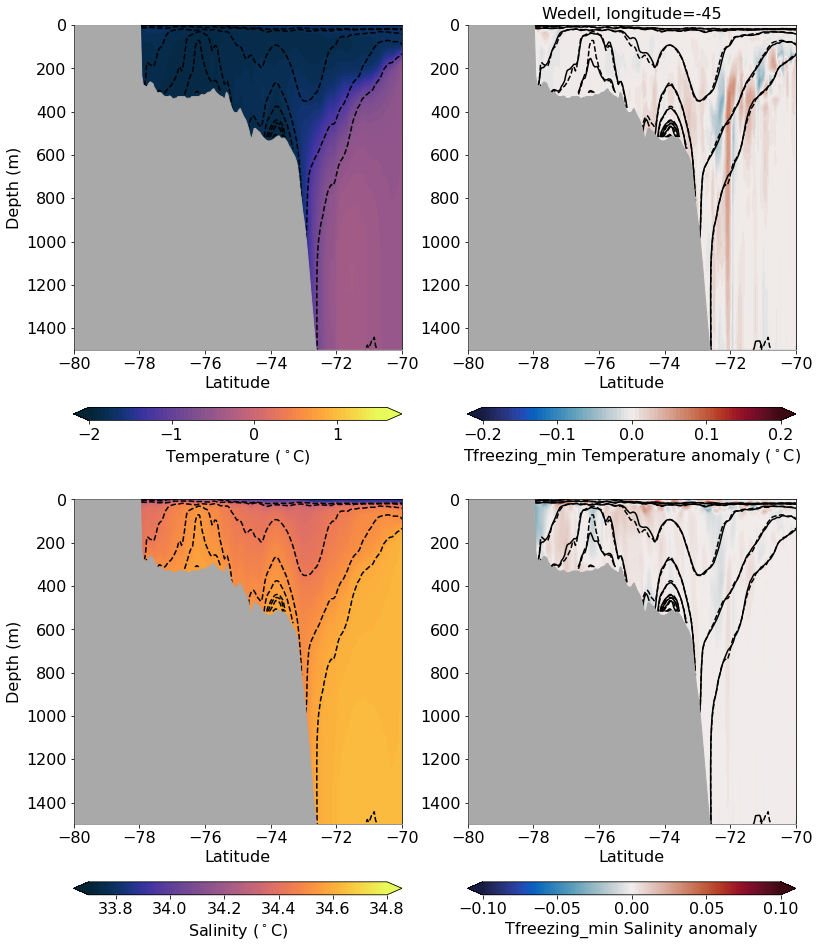

In [55]:
plot_transects('Wedell')

2022-09-22 13:00:03,397 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-22 13:00:03,438 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2022-09-22 13:00:04,443 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:04,827 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-09-22 13:00:05,759 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:00:06,767 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-09-22 13:00:07,499 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:00:08,640 - distributed.utils_perf - WARNING - full garbage collections took

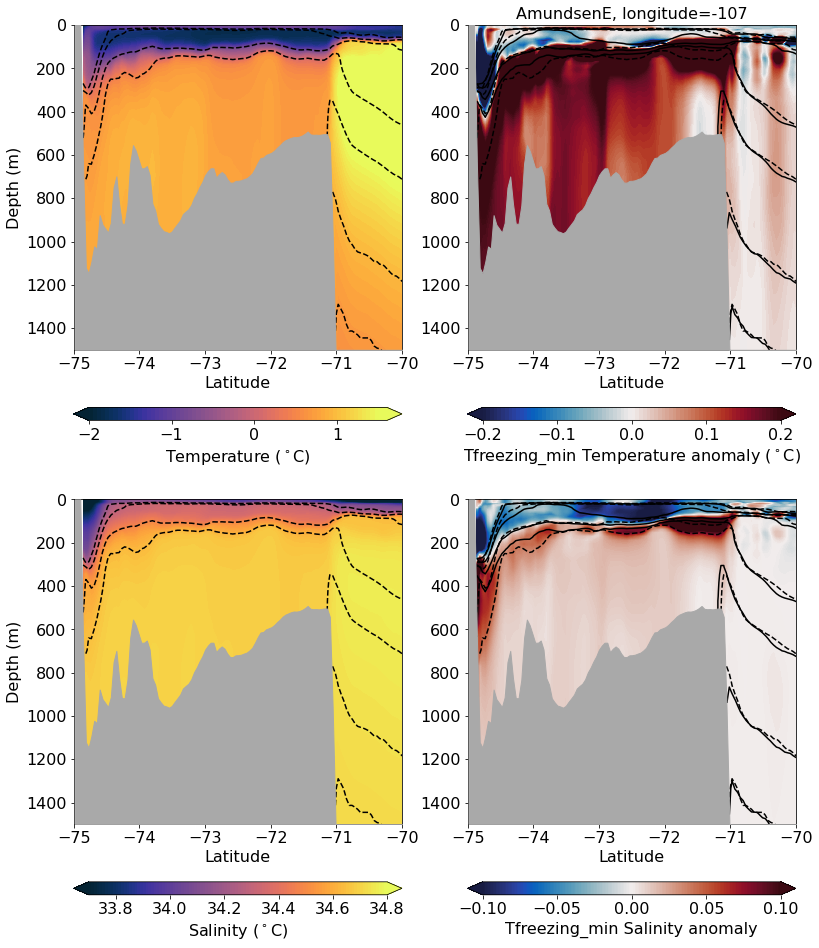

In [56]:
plot_transects('AmundsenE')

2022-09-22 13:00:11,854 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-09-22 13:00:12,524 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:12,549 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:00:13,709 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-09-22 13:00:14,582 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:00:15,998 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:16,018 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:00:16,367 - distributed.utils_perf - WARNING - full garbage collections took

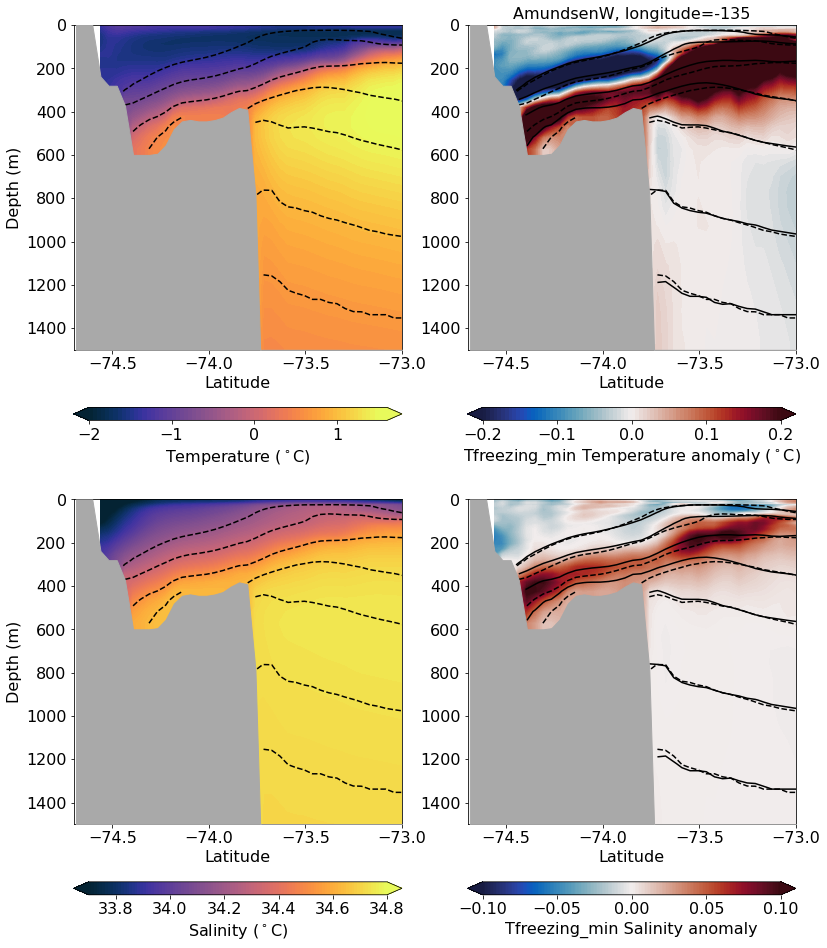

In [57]:
plot_transects('AmundsenW')

2022-09-22 13:00:21,026 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:00:21,435 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-09-22 13:00:22,834 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-09-22 13:00:23,378 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:00:24,762 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:00:24,768 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:24,768 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:25,194 - distributed.utils_perf - WARNING - full garbage collections took

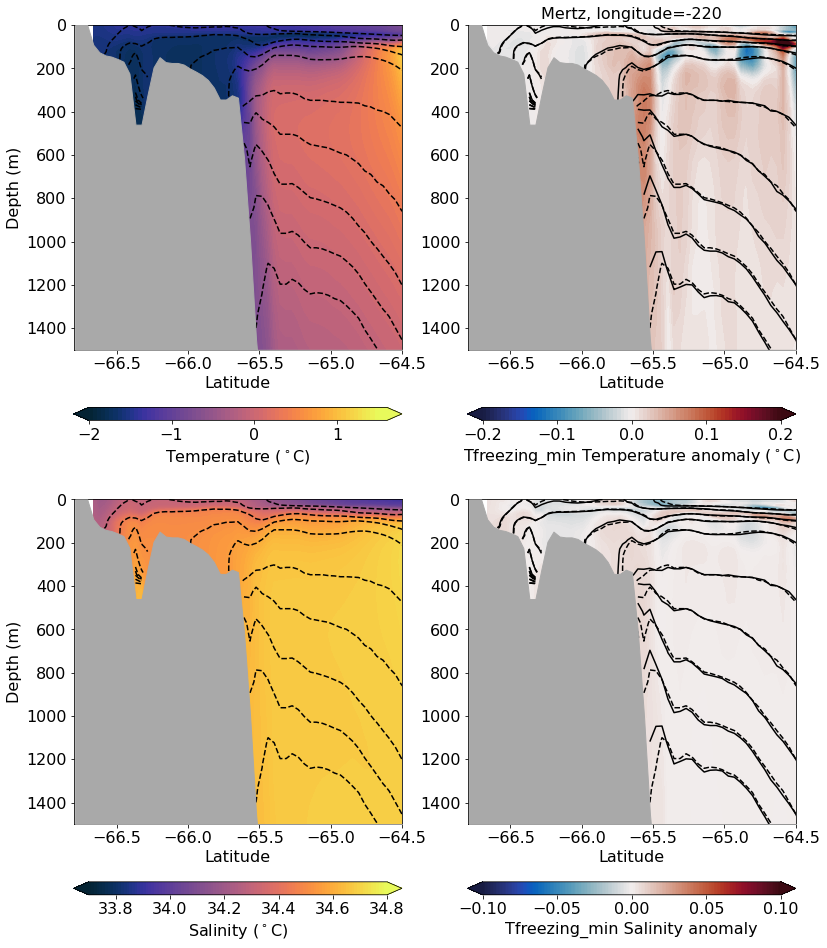

In [58]:
plot_transects('Mertz')

2022-09-22 13:00:30,693 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-09-22 13:00:31,750 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2022-09-22 13:00:31,766 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:31,800 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:00:32,198 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-09-22 13:00:32,827 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:34,749 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:35,101 - distributed.utils_perf - WARNING - full garbage collections took

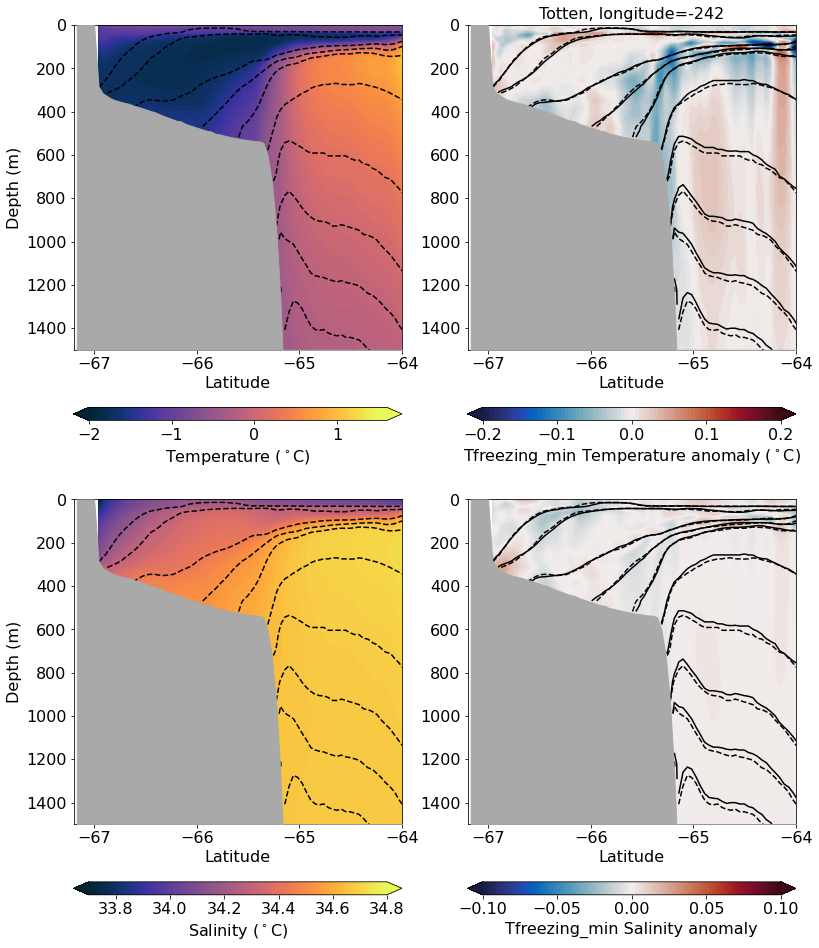

In [59]:
plot_transects('Totten')

2022-09-22 13:00:40,077 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2022-09-22 13:00:40,078 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:40,098 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:40,464 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-09-22 13:00:41,546 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:00:42,739 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-09-22 13:00:43,394 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:44,582 - distributed.utils_perf - WARNING - full garbage collections took

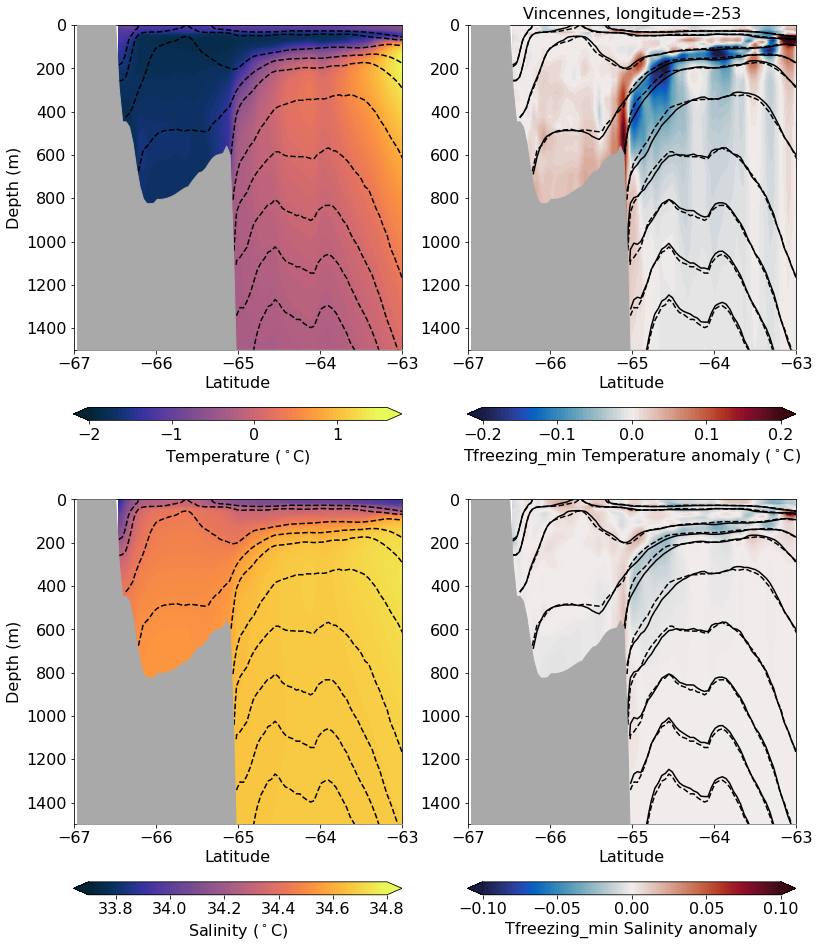

In [60]:
plot_transects('Vincennes')

2022-09-22 13:00:48,335 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-09-22 13:00:49,815 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:50,045 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:50,097 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:00:50,457 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-09-22 13:00:51,535 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:00:53,060 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:53,383 - distributed.utils_perf - WARNING - full garbage collections took

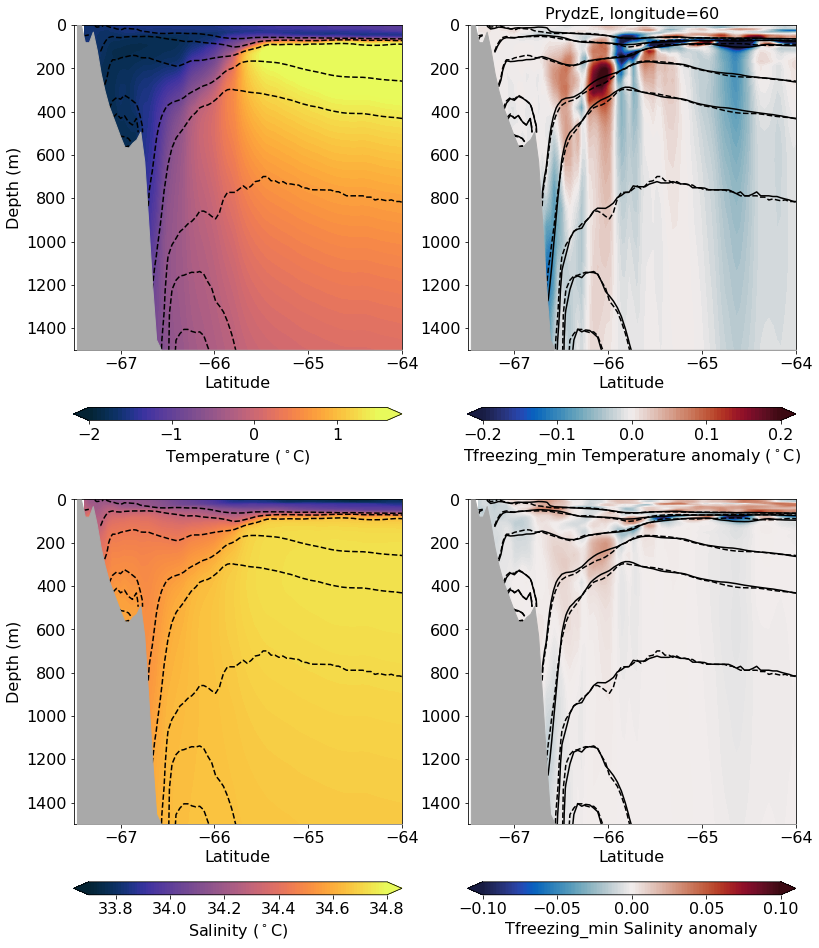

In [61]:
plot_transects('PrydzE')

2022-09-22 13:00:58,578 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:00:58,948 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-09-22 13:00:59,903 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:01:00,797 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-22 13:01:00,864 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-09-22 13:01:01,158 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-09-22 13:01:02,711 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-09-22 13:01:04,334 - distributed.utils_perf - WARNING - full garbage collections took

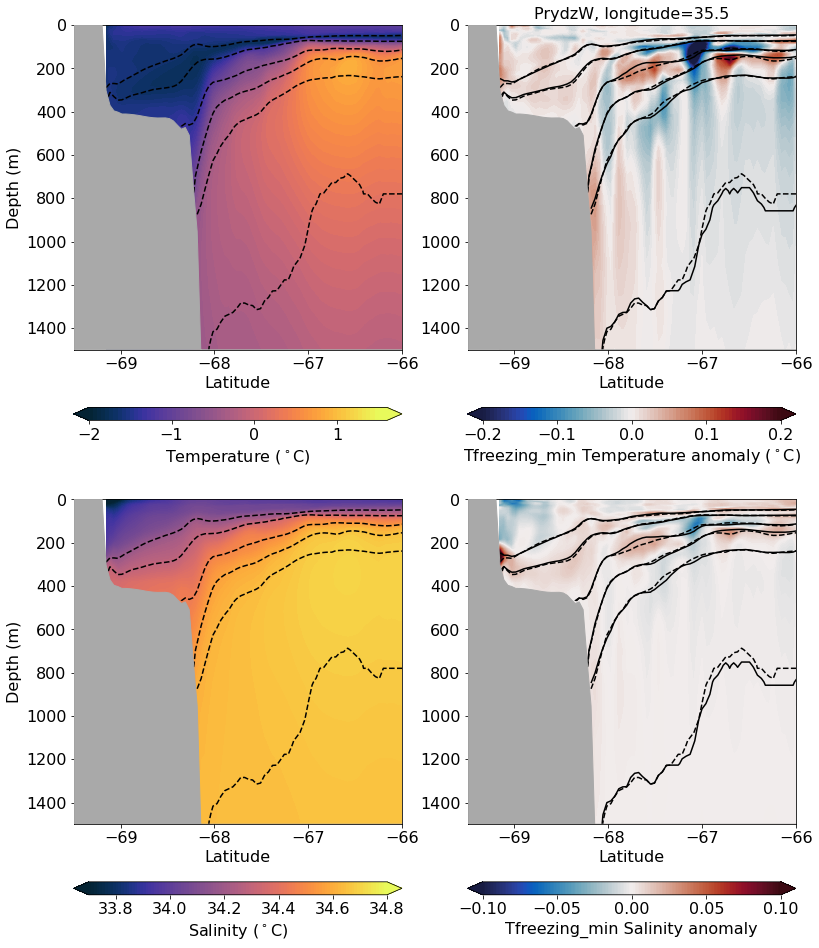

In [62]:
plot_transects('PrydzW')